In [6]:
# Set up simple CNN for MNIST hand-written digits image recognition
#import the necessary libraries 
%matplotlib inline

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Layer
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import math


In [7]:
#FILTERS
blur_filter = np.array([[0.0625,0.125,0.0625],[0.125,0.250,0.125],[0.0625,0.125,0.0625]], dtype=np.float32)
outline_filter = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]], dtype=np.float32)
emboss_filter = np.array([[-2,-1,0],[-1,1,1],[0,1,2]], dtype=np.float32)

#FILTER USED 
global used_filter
used_filter = blur_filter

#GLOBAL VARIABLES
global DIM
DIM = 8
global FL
FL = 4
global IL
IL = 8
global e
e = pow(2,-FL)
global n_max
n_max = pow(2,IL-1) - e
global n_min
n_min = -1*pow(2,IL-1)

In [8]:
#ELABORATION
def elaboration(P):
    N = P // e
    p = (P - N*e) / e
    rand = np.random.normal(0,1,1)
    if rand <= p:
        return N*e
    else:
        return (N+1)*e

In [9]:
#CONVERSION
def conversion(Z):
    if Z > n_max:
        return n_max
    elif Z < n_min:
        return n_min
    else:
        return Z

In [10]:
def convert_and_compute(P):
    P = P/pow(2,FL)
    P = conversion( elaboration(P) )
    pix = int(P)
    return pix

In [11]:
#CONVERSION
def conv(image):
    output = image.astype(int)
    width = len(image)
    height = len(image[0])
    
    for i in range(0,width):
    #iterating in a column
        for j in range(0,height):
            #iterating in greyscale
            output[i][j] = convert_and_compute(image[i][j])
   
    return output

In [12]:
#KERNEL preprocessing
def kernel_preprocessing(kernel):
    kernel = np.array([1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]).reshape(3,3)
    
    for i in range(0,3):
        for j in range(0,3):
            kernel[i][j] = conversion( elaboration(kernel[i][j]) )
    
    return kernel

In [13]:
#IMAGE preprocessing
def image_preprocessing(image):
    #shift of FL to left bits of the image pixels
    npImage = np.array(image).astype(np.float32)
    width = len(npImage)
    height = len(npImage[0])

    for i in range(0,width):
    #iterating in a column
        for j in range(0,height):
            npImage[i][j] = npImage[i][j]*pow(2,FL)
    
    return npImage

In [14]:
#IMAGE postprocessing
def image_postprocessing(image_convoluted):
    return conv(image_convoluted)

In [15]:
class Conv2DStochastic(Layer):
    def __init__(self, filters, kernel_size, kernel_initializer, **kwargs):
        self.filters = filters
        self.kernel_initializer=kernel_initializer
        self.kernel_size = kernel_size
        super(Conv2DStochastic, self).__init__(**kwargs)
        

    def call(self):
        #find out how to get the INPUTS from the PIPELINE
        kernel_preprocessed = kernel_preprocessing(K.eval(self.kernel_initializer))
        image_preprocessed = image_preprocessing(K.eval(model.input))
        image_processed = K.conv2d(image_preprocessed, kernel_preprocessed)
        return K.constant(image_postprocessing(image_processed))


In [16]:
mnist = tf.keras.datasets.mnist

7


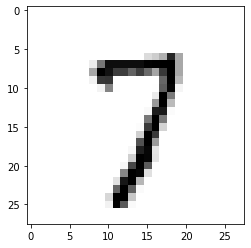

In [17]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

image_index = 258 # You may select anything up to 60,000
print(y_train[image_index]) # The label 
plt.imshow(x_train[image_index], cmap='Greys')

In [18]:
#check the shape of the imput elements

x_train.shape

(60000, 28, 28)

In [19]:
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000


In [20]:
# Importing the required Keras modules containing model and layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [21]:
# Creating a Sequential Model and adding the layers
model = Sequential()
model.add(Conv2D(28, kernel_size=(3, 3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))

In [22]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [23]:
model.fit(x=x_train,y=y_train, epochs=1)

1875/1875 [==============================] - 36s 19ms/step - loss: 0.3550 - accuracy: 0.8937


In [24]:
#LAYER1
for i in range(0, 100):    
    weights = model.layers[0].get_weights()[0]
    shape = np.shape(model.layers[0].get_weights()[0])
    weights = weights.reshape(model.layers[0].get_weights()[0].size)
    new_weights = np.zeros(shape=np.shape(weights))
    for i in range(0,weights.size):
        new_weights[i]= conversion( elaboration(weights[i]) )
    new_weights = new_weights.reshape(shape)
    
    biases = model.layers[0].get_weights()[1]
    shapeb = np.shape(model.layers[0].get_weights()[1])
    biases = biases.reshape(model.layers[0].get_weights()[1].size)
    new_biases = np.zeros(shape=np.shape(biases))
    for i in range(0,biases.size):
        new_biases[i]= conversion( elaboration(biases[i]) )
    new_biases = new_biases.reshape(shapeb)    
    
    w_b = []
    w_b.append(new_weights)
    w_b.append(new_biases)
    
    model.layers[0].set_weights(w_b)  

    #print(model.layers[0].get_weights()[0])
    history=model.fit(x=x_train,y=y_train, epochs=200)

Epoch 1/200
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0831 - accuracy: 0.9743
Epoch 2/200
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0576 - accuracy: 0.9821
Epoch 3/200
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0447 - accuracy: 0.9854
Epoch 4/200
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0335 - accuracy: 0.9888
Epoch 5/200
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0305 - accuracy: 0.9900
Epoch 6/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0253 - accuracy: 0.9913
Epoch 7/200
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0208 - accuracy: 0.9929
Epoch 8/200
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0198 - accuracy: 0.9932
Epoch 9/200
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0176 - accuracy: 0.99400s - loss: 0
Epoch 10/200
1875/1875 [===================

Epoch 78/200
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0079 - accuracy: 0.9982
Epoch 79/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0070 - accuracy: 0.9983
Epoch 80/200
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0075 - accuracy: 0.99830s - los
Epoch 81/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0063 - accuracy: 0.9985
Epoch 82/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0069 - accuracy: 0.9983
Epoch 83/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0069 - accuracy: 0.9985
Epoch 84/200
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0070 - accuracy: 0.9984
Epoch 85/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0077 - accuracy: 0.9981
Epoch 86/200
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0063 - accuracy: 0.9985
Epoch 87/200
1875/1875 [==============

1875/1875 [==============================] - 32s 17ms/step - loss: 0.0070 - accuracy: 0.9987
Epoch 155/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0076 - accuracy: 0.9986
Epoch 156/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0061 - accuracy: 0.9987
Epoch 157/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0065 - accuracy: 0.9990
Epoch 158/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0076 - accuracy: 0.99870s - loss: 0.0077 - accuracy
Epoch 159/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0062 - accuracy: 0.9988
Epoch 160/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0078 - accuracy: 0.9987
Epoch 161/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0085 - accuracy: 0.9989
Epoch 162/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0053 - accuracy: 0.9991
Epoch 163/200
1875/1875

1875/1875 [==============================] - 31s 17ms/step - loss: 0.0050 - accuracy: 0.9991
Epoch 29/200
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0078 - accuracy: 0.9989
Epoch 30/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0066 - accuracy: 0.9991
Epoch 31/200
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0083 - accuracy: 0.9988
Epoch 32/200
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0089 - accuracy: 0.9989
Epoch 33/200
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0077 - accuracy: 0.9989
Epoch 34/200
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0063 - accuracy: 0.9990
Epoch 35/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0064 - accuracy: 0.9990
Epoch 36/200
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0043 - accuracy: 0.9993
Epoch 37/200
1875/1875 [==============================] - 3

1875/1875 [==============================] - 31s 17ms/step - loss: 0.0088 - accuracy: 0.9992
Epoch 104/200
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0120 - accuracy: 0.9991
Epoch 105/200
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0050 - accuracy: 0.9993
Epoch 106/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0073 - accuracy: 0.9992
Epoch 107/200
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0045 - accuracy: 0.9992
Epoch 108/200
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0075 - accuracy: 0.9993
Epoch 109/200
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0068 - accuracy: 0.9992
Epoch 110/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0060 - accuracy: 0.99940s - loss: 0.0
Epoch 111/200
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0059 - accuracy: 0.9994
Epoch 112/200
1875/1875 [============

1875/1875 [==============================] - 32s 17ms/step - loss: 0.0073 - accuracy: 0.9992
Epoch 180/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0102 - accuracy: 0.9993
Epoch 181/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0079 - accuracy: 0.9992
Epoch 182/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0064 - accuracy: 0.9995
Epoch 183/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0081 - accuracy: 0.9991
Epoch 184/200
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0085 - accuracy: 0.9993
Epoch 185/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0057 - accuracy: 0.9994
Epoch 186/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0061 - accuracy: 0.9994
Epoch 187/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0094 - accuracy: 0.9993
Epoch 188/200
1875/1875 [==========================

1875/1875 [==============================] - 32s 17ms/step - loss: 0.0077 - accuracy: 0.9993
Epoch 56/200
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0142 - accuracy: 0.9992
Epoch 57/200
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0069 - accuracy: 0.9994
Epoch 58/200
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0110 - accuracy: 0.9992
Epoch 59/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0089 - accuracy: 0.9993
Epoch 60/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0046 - accuracy: 0.9996
Epoch 61/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0069 - accuracy: 0.9995
Epoch 62/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0130 - accuracy: 0.9992
Epoch 63/200
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0073 - accuracy: 0.9995
Epoch 64/200
1875/1875 [==============================] - 3

1875/1875 [==============================] - 33s 17ms/step - loss: 0.0099 - accuracy: 0.9994
Epoch 132/200
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0082 - accuracy: 0.9993
Epoch 133/200
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0066 - accuracy: 0.9996
Epoch 134/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0083 - accuracy: 0.9995
Epoch 135/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0139 - accuracy: 0.9994
Epoch 136/200
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0100 - accuracy: 0.9992
Epoch 137/200
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0071 - accuracy: 0.9995
Epoch 138/200
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0064 - accuracy: 0.9996
Epoch 139/200
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0068 - accuracy: 0.9995
Epoch 140/200
1875/1875 [==========================

1875/1875 [==============================] - 32s 17ms/step - loss: 0.0099 - accuracy: 0.9993
Epoch 8/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0068 - accuracy: 0.9995
Epoch 9/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0090 - accuracy: 0.9994
Epoch 10/200
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0086 - accuracy: 0.9995
Epoch 11/200
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0076 - accuracy: 0.9995
Epoch 12/200
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0087 - accuracy: 0.9994
Epoch 13/200
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0098 - accuracy: 0.99940s - loss: 0.0099 - 
Epoch 14/200
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0083 - accuracy: 0.9994
Epoch 15/200
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0051 - accuracy: 0.9996
Epoch 16/200
1875/1875 [=================

1875/1875 [==============================] - 32s 17ms/step - loss: 0.0035 - accuracy: 0.9997
Epoch 84/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0097 - accuracy: 0.9993
Epoch 85/200
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0062 - accuracy: 0.9996
Epoch 86/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0046 - accuracy: 0.9997
Epoch 87/200
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0074 - accuracy: 0.9996
Epoch 88/200
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0082 - accuracy: 0.9995
Epoch 89/200
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0049 - accuracy: 0.9996
Epoch 90/200
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0068 - accuracy: 0.9995
Epoch 91/200
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0082 - accuracy: 0.9995
Epoch 92/200
1875/1875 [==============================] - 3

1875/1875 [==============================] - 32s 17ms/step - loss: 0.0073 - accuracy: 0.9996
Epoch 160/200
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0097 - accuracy: 0.9995
Epoch 161/200
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0047 - accuracy: 0.9997
Epoch 162/200
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0103 - accuracy: 0.9995
Epoch 163/200
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0075 - accuracy: 0.9995
Epoch 164/200
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0051 - accuracy: 0.9997
Epoch 165/200
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0087 - accuracy: 0.9995
Epoch 166/200
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0066 - accuracy: 0.9997
Epoch 167/200
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0066 - accuracy: 0.9995
Epoch 168/200
1875/1875 [==========================

KeyboardInterrupt: 

In [25]:
import pandas as pd 
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history200.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
image_index = 5960
plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')
pred = model.predict(x_test[image_index].reshape(1, 28, 28, 1))
print(pred.argmax())

In [26]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model200.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Dell\AppData\Local\Temp\tmpx87i17z5\assets
